## **EDA Análisis exploratorio de los datos: Regresión Lineal** 

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import seaborn as sns

In [73]:
route = './data/HISTORICO_SUERTES.xlsx'
df = pd.read_excel(route)

In [74]:
df_clean = df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21027 entries, 0 to 21026
Data columns (total 85 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Período                    21027 non-null  int64         
 1   Hacienda                   21027 non-null  int64         
 2   Nombre                     21027 non-null  object        
 3   Zona                       21027 non-null  object        
 4   Tenencia                   21026 non-null  float64       
 5   Suerte                     21027 non-null  object        
 6   Suelo                      17269 non-null  object        
 7   Area Neta                  21027 non-null  float64       
 8   Dist Km                    21022 non-null  float64       
 9   Variedad                   21027 non-null  object        
 10  Cod.Estado #               21027 non-null  int64         
 11  Cod.Estado                 21027 non-null  object        
 12  F.Si

In [75]:
df.head(3)

Período  Hacienda           Nombre  Zona  Tenencia Suerte       Suelo  \
0   201701     80493        LA CONCHA  IP02      51.0   002A   CANTARINA   
1   201701     81284  UKRANIA INCAUCA  IP05      81.0   039B         NaN   
2   201701     80203    EL AMPARO SAA  IP05      31.0    007  CORINTIAS    

   Area Neta  Dist Km   Variedad  ...  Humedad Rel Media Ciclo  \
0       6.00      4.3    CC85-92  ...                      NaN   
1       1.45      NaN    CC85-92  ...                      NaN   
2       8.24     23.0  CC01-1228  ...                      NaN   

  Oscilacion Temp Med 0-3 Oscilacion Temp Ciclo Sum Oscilacion Temp Ciclo  \
0                     NaN                   NaN                       NaN   
1                     NaN                   NaN                       NaN   
2                     NaN                   NaN                       NaN   

  Radicion Solar 0-3  Radiacion Solar Ciclo Precipitacion 0_3  \
0                NaN                    NaN               NaN   
1                NaN                    NaN               NaN   
2                NaN                    NaN               NaN   

   Precipitacion Ciclo  Evaporacion 0-3 Evaporacion Ciclo  
0                  NaN              NaN               NaN  
1                  NaN              NaN               NaN  
2                  NaN              NaN               NaN  

[3 rows x 85 columns]

---
## **Limpieza y preparación de datos**

#### **Data Leakage**
Se identifican variables no relevantes relacionadas con información de las haciendas. 

In [76]:
DATA_LEAKAGE = ['Hacienda', 'Nombre', 'Zona', 'Codigo Estacion']
df = df.drop(columns = DATA_LEAKAGE)

#### **Datos Nulos**
Se extraen porcentajes de nulos para identificar features a eliminar, a imputar y si existen similitudes entre las mismas. 

In [77]:
null_percent = df.isnull().mean() * 100
null_percent.sort_values(ascending=False).head(50)

Sum Oscilacion Temp Ciclo    100.000000
Fert.Nitrogen.               100.000000
Urea 46%                      96.561564
NITRAX-S                      96.442669
MEZ                           95.382128
MicroZinc                     94.535597
Boro Granul.                  93.888810
Sul.Amonio                    93.546393
NITO_XTEND                    82.503448
Vinaza                        80.510772
Temp. Media Ciclo             78.456271
Temp. Media 0-3               78.456271
Humedad Rel Media Ciclo       78.456271
Humedad Rel Media 0-3         78.456271
Temp Min Ciclo                78.456271
Temp Max Ciclo                78.456271
Evaporacion Ciclo             78.456271
Radiacion Solar Ciclo         78.456271
Evaporacion 0-3               78.456271
Precipitacion Ciclo           78.456271
Precipitacion 0_3             78.456271
Oscilacion Temp Ciclo         78.456271
Radicion Solar 0-3            78.456271
Oscilacion Temp Med 0-3       78.456271
%Infest.Diatrea               73.367575


#### **Columnas Vacías**

Eliminamos columnas vacías del Df


In [78]:
COLUMNS_TO_DROP = ['Sum Oscilacion Temp Ciclo', 'Fert.Nitrogen.']
df = df.drop(columns = COLUMNS_TO_DROP)

#### **Chem Features**

Se observan columnas con porcentajes de nulos demasiado altos [99% - 80%]. Parecen columnas relacionadas a productos o químicos que se utilizaron en la plantación, su ausencia podría indicar que el producto no se usó. Se imputarán con 0's. 


In [79]:
CHEM_FEATURES = ['Urea 46%', 'NITRAX-S', 'MEZ', 'NITO_XTEND', 'Vinaza', 'MicroZinc', 'Boro Granul.', 'Sul.Amonio']
df[CHEM_FEATURES] = df[CHEM_FEATURES].fillna(0)

#### **Weather Features - Variables Climaticas**
Se observa un porcentaje en común con variables relacionadas con condiciones climáticas (78.456271%) por esa razón, se procede a agruparlas en la categoría de weather features

In [80]:
WEATHER_FEATURES = ['Humedad Rel Media Ciclo', 'Temp. Media 0-3', 'Oscilacion Temp Med 0-3', 'Temp. Media Ciclo', 'Temp Max Ciclo', 'Humedad Rel Media 0-3 ', 'Radiacion Solar Ciclo', 'Evaporacion 0-3', 'Precipitacion Ciclo', 'Evaporacion Ciclo', 'Temp Min Ciclo', 'Oscilacion Temp Ciclo', 'Radicion Solar 0-3', 'Precipitacion 0_3']

Al revisar el dataset, se observa que existen variables del clima como radiación solar, ciclos de evaporación, entre otros, que comparten el mismo porcentaje de nulos, al revisar los campos no nulos se observa que solo se tienen registros de estas variables desde el periodo 202202 hasta 202407, teniendo un total de 4.530 de 20.027 que habían originalmente. Para revisar si son relevantes para el modelo, se propone analizar su correlación con la variable objetivo. 

In [104]:
## Subset
df_filtered_weather = df.dropna(subset=WEATHER_FEATURES, how="any")

In [118]:
numeric_df_filtered_weather = df_filtered_weather.select_dtypes(include=['float64', 'int64'])
numeric_df_filtered_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4530 entries, 13972 to 21026
Data columns (total 64 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Período                  4530 non-null   int64  
 1   Tenencia                 4530 non-null   float64
 2   Area Neta                4530 non-null   float64
 3   Dist Km                  4530 non-null   float64
 4   Cod.Estado #             4530 non-null   int64  
 5   Edad Ult Cos             4530 non-null   float64
 6   Destino 1=Semilla        4530 non-null   int64  
 7   Cod. T.Cultivo           4530 non-null   float64
 8   Dosis Madurante          4522 non-null   float64
 9   Semanas mad.             2225 non-null   float64
 10  TonUltCorte              4530 non-null   float64
 11  TCH                      4530 non-null   float64
 12  TCHM                     4530 non-null   float64
 13  Ton.Azucar               4453 non-null   float64
 14  Rdto                    

In [119]:
numeric_df_filtered_weather['Período_Mes'] = numeric_df_filtered_weather['Período'].astype(str).str[-2:].astype(int)

In [120]:
numeric_df_filtered_weather = numeric_df_filtered_weather.drop(columns =['Período'])

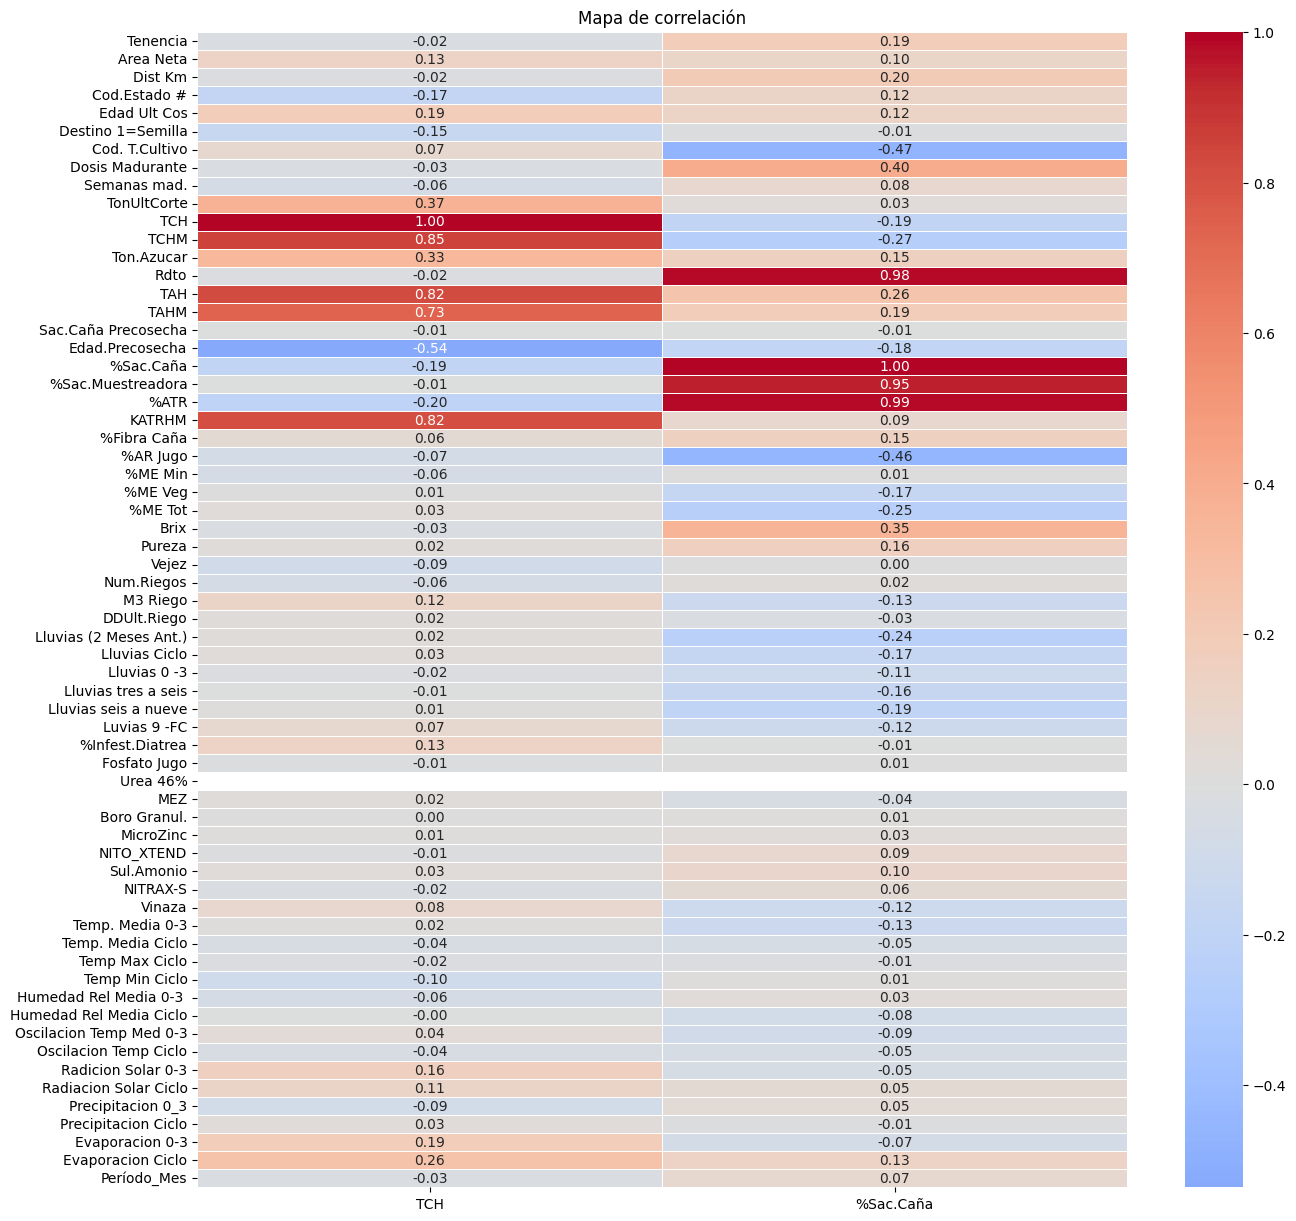

In [121]:
corr_weather_filtered = numeric_df_filtered_weather.corr()

plt.figure(figsize=(15,15))
sns.heatmap(corr_weather_filtered[["TCH", "%Sac.Caña"]], 
            annot=True,
            cmap="coolwarm", 
            center=0,        
            fmt=".2f",       
            linewidths=0.5)  

plt.title("Mapa de correlación")
plt.show()

No se observan valores de correlación relevantes a excepción de evaporación ciclo, que si bien no es alto comparado con otras features, en las features de su grupo fue el valor mas alto. Se analiza tambien el mapa de correlación general tanto del subset como del set original.

#### **Matriz de correlación de subset (filtrado por las features de clima)**

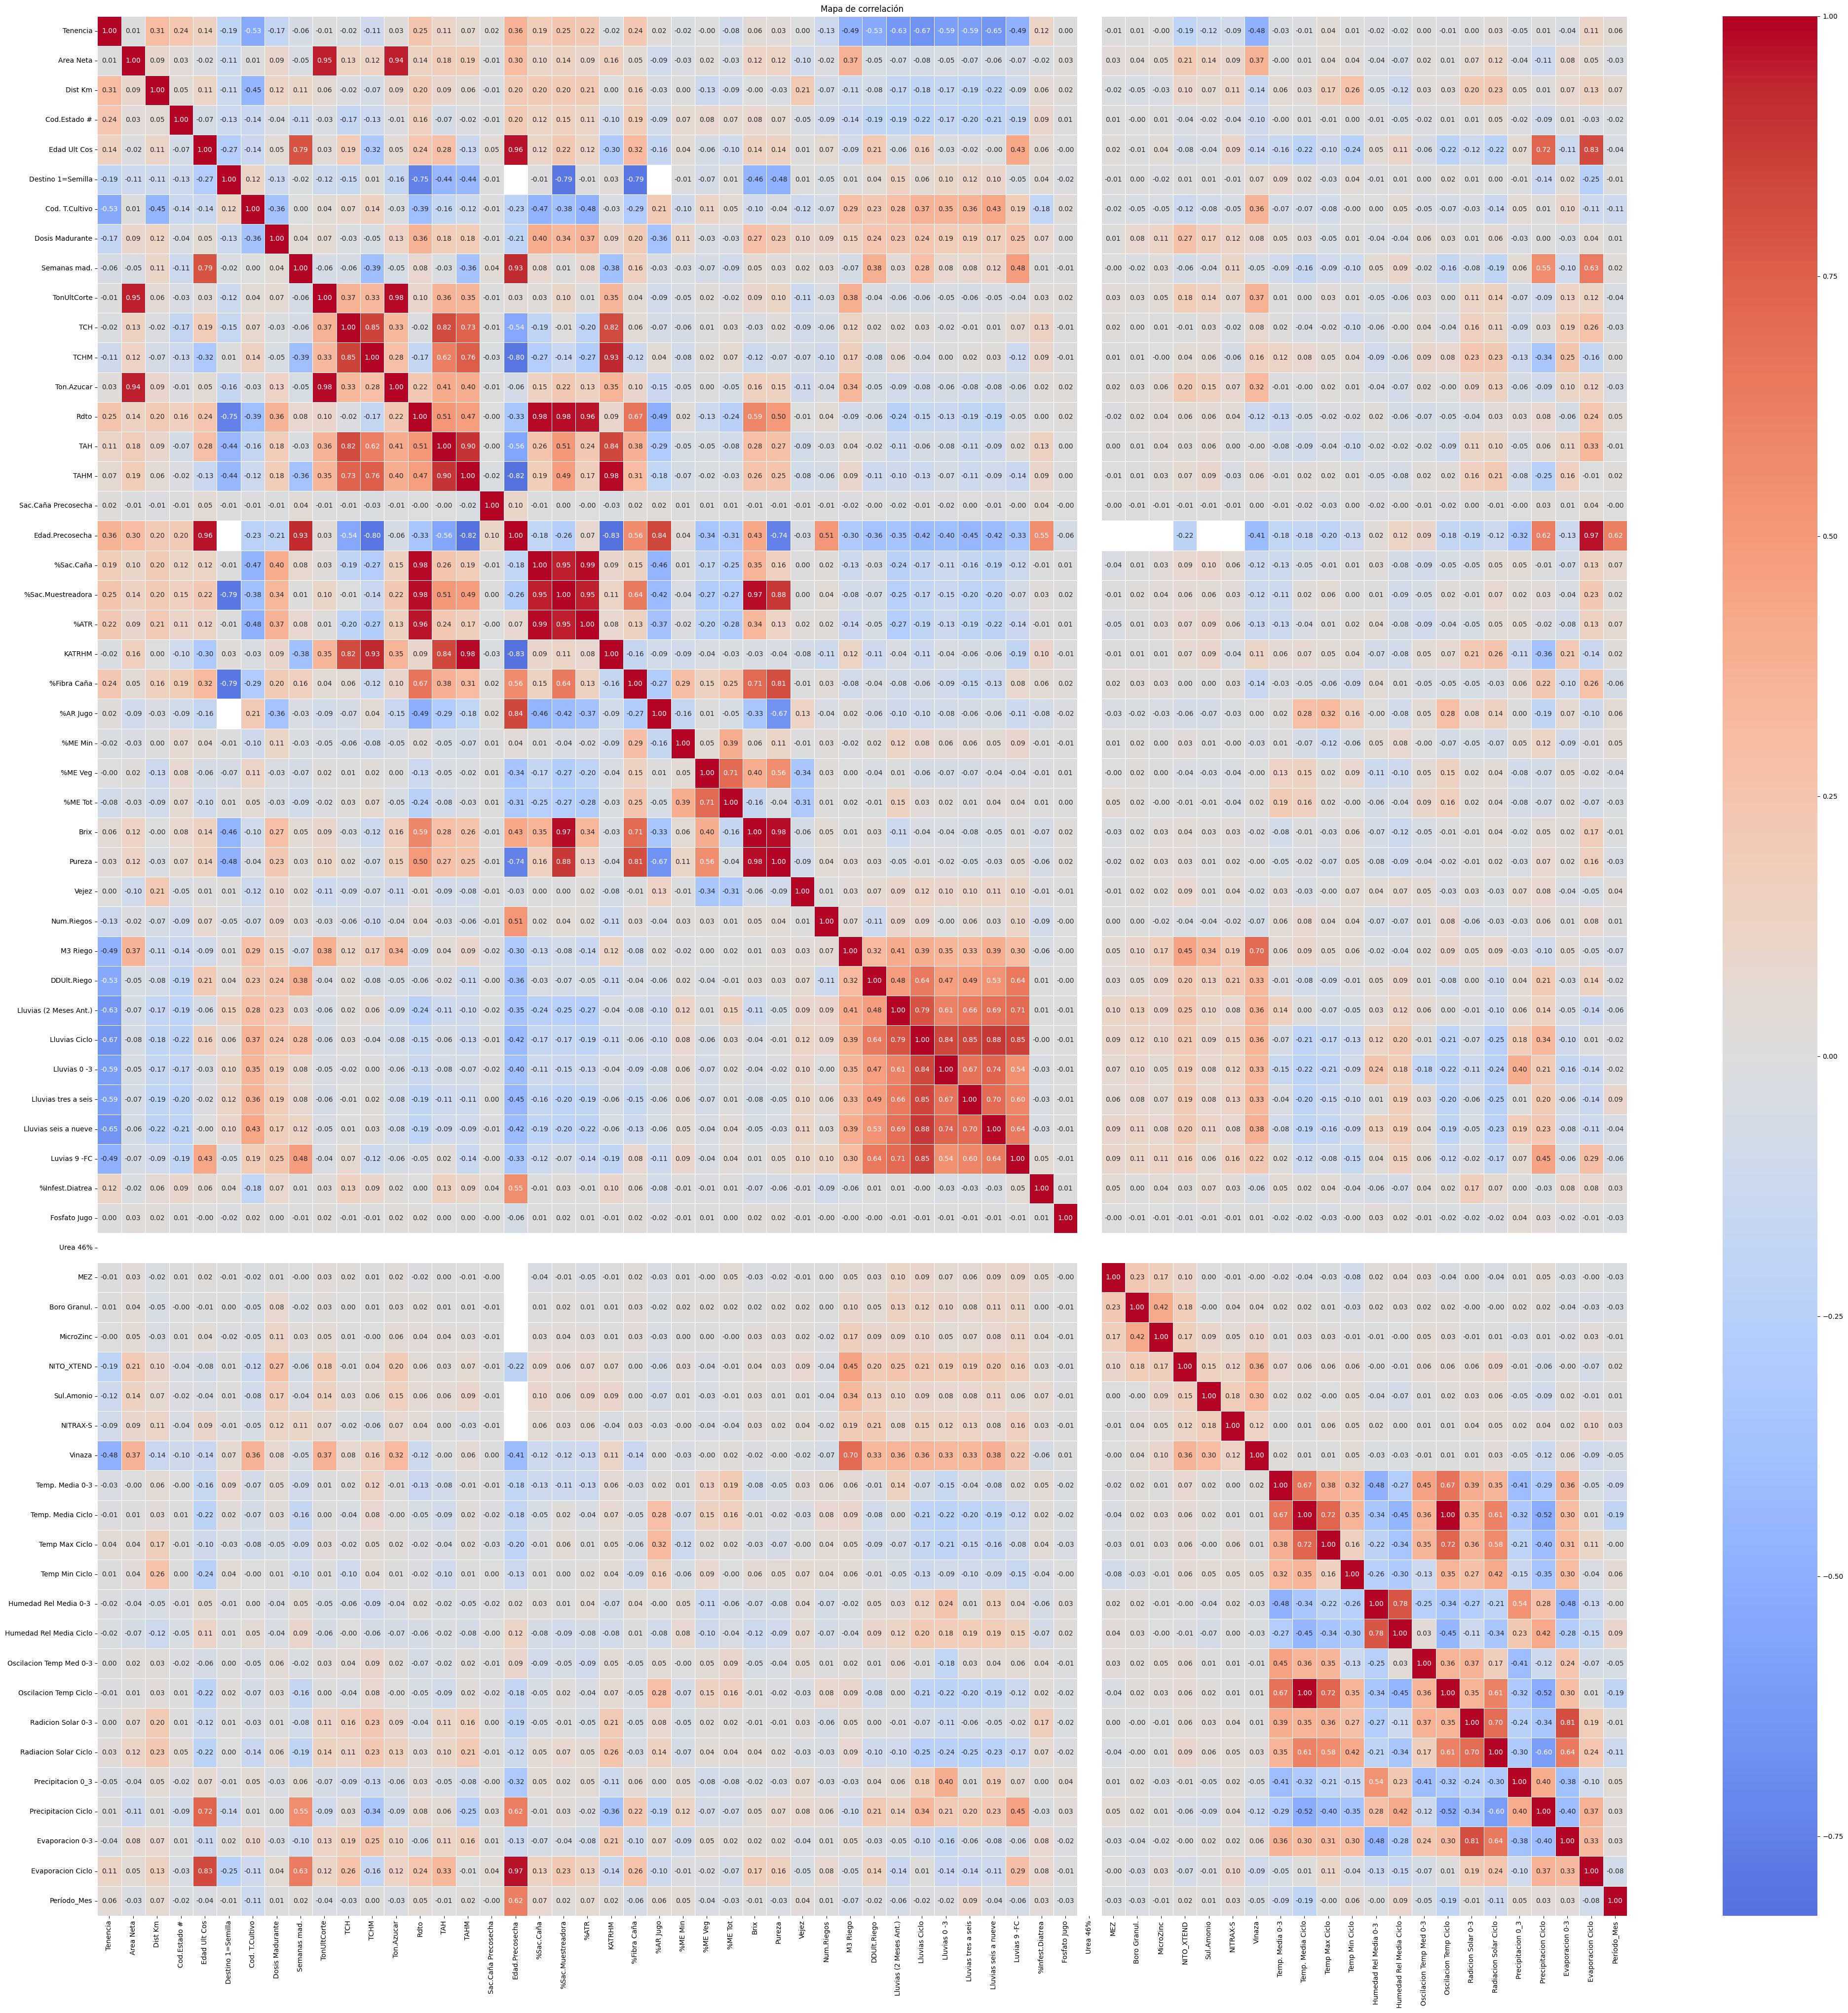

In [ ]:
## Subset 
plt.figure(figsize=(50,50))
sns.heatmap(corr_weather_filtered, 
            annot=True,     
            cmap="coolwarm", 
            center=0,      
            fmt=".2f",
            linewidths=0.5)  

plt.title("Mapa de correlación")
plt.show()

#### **Matriz de correlación de dataset original**

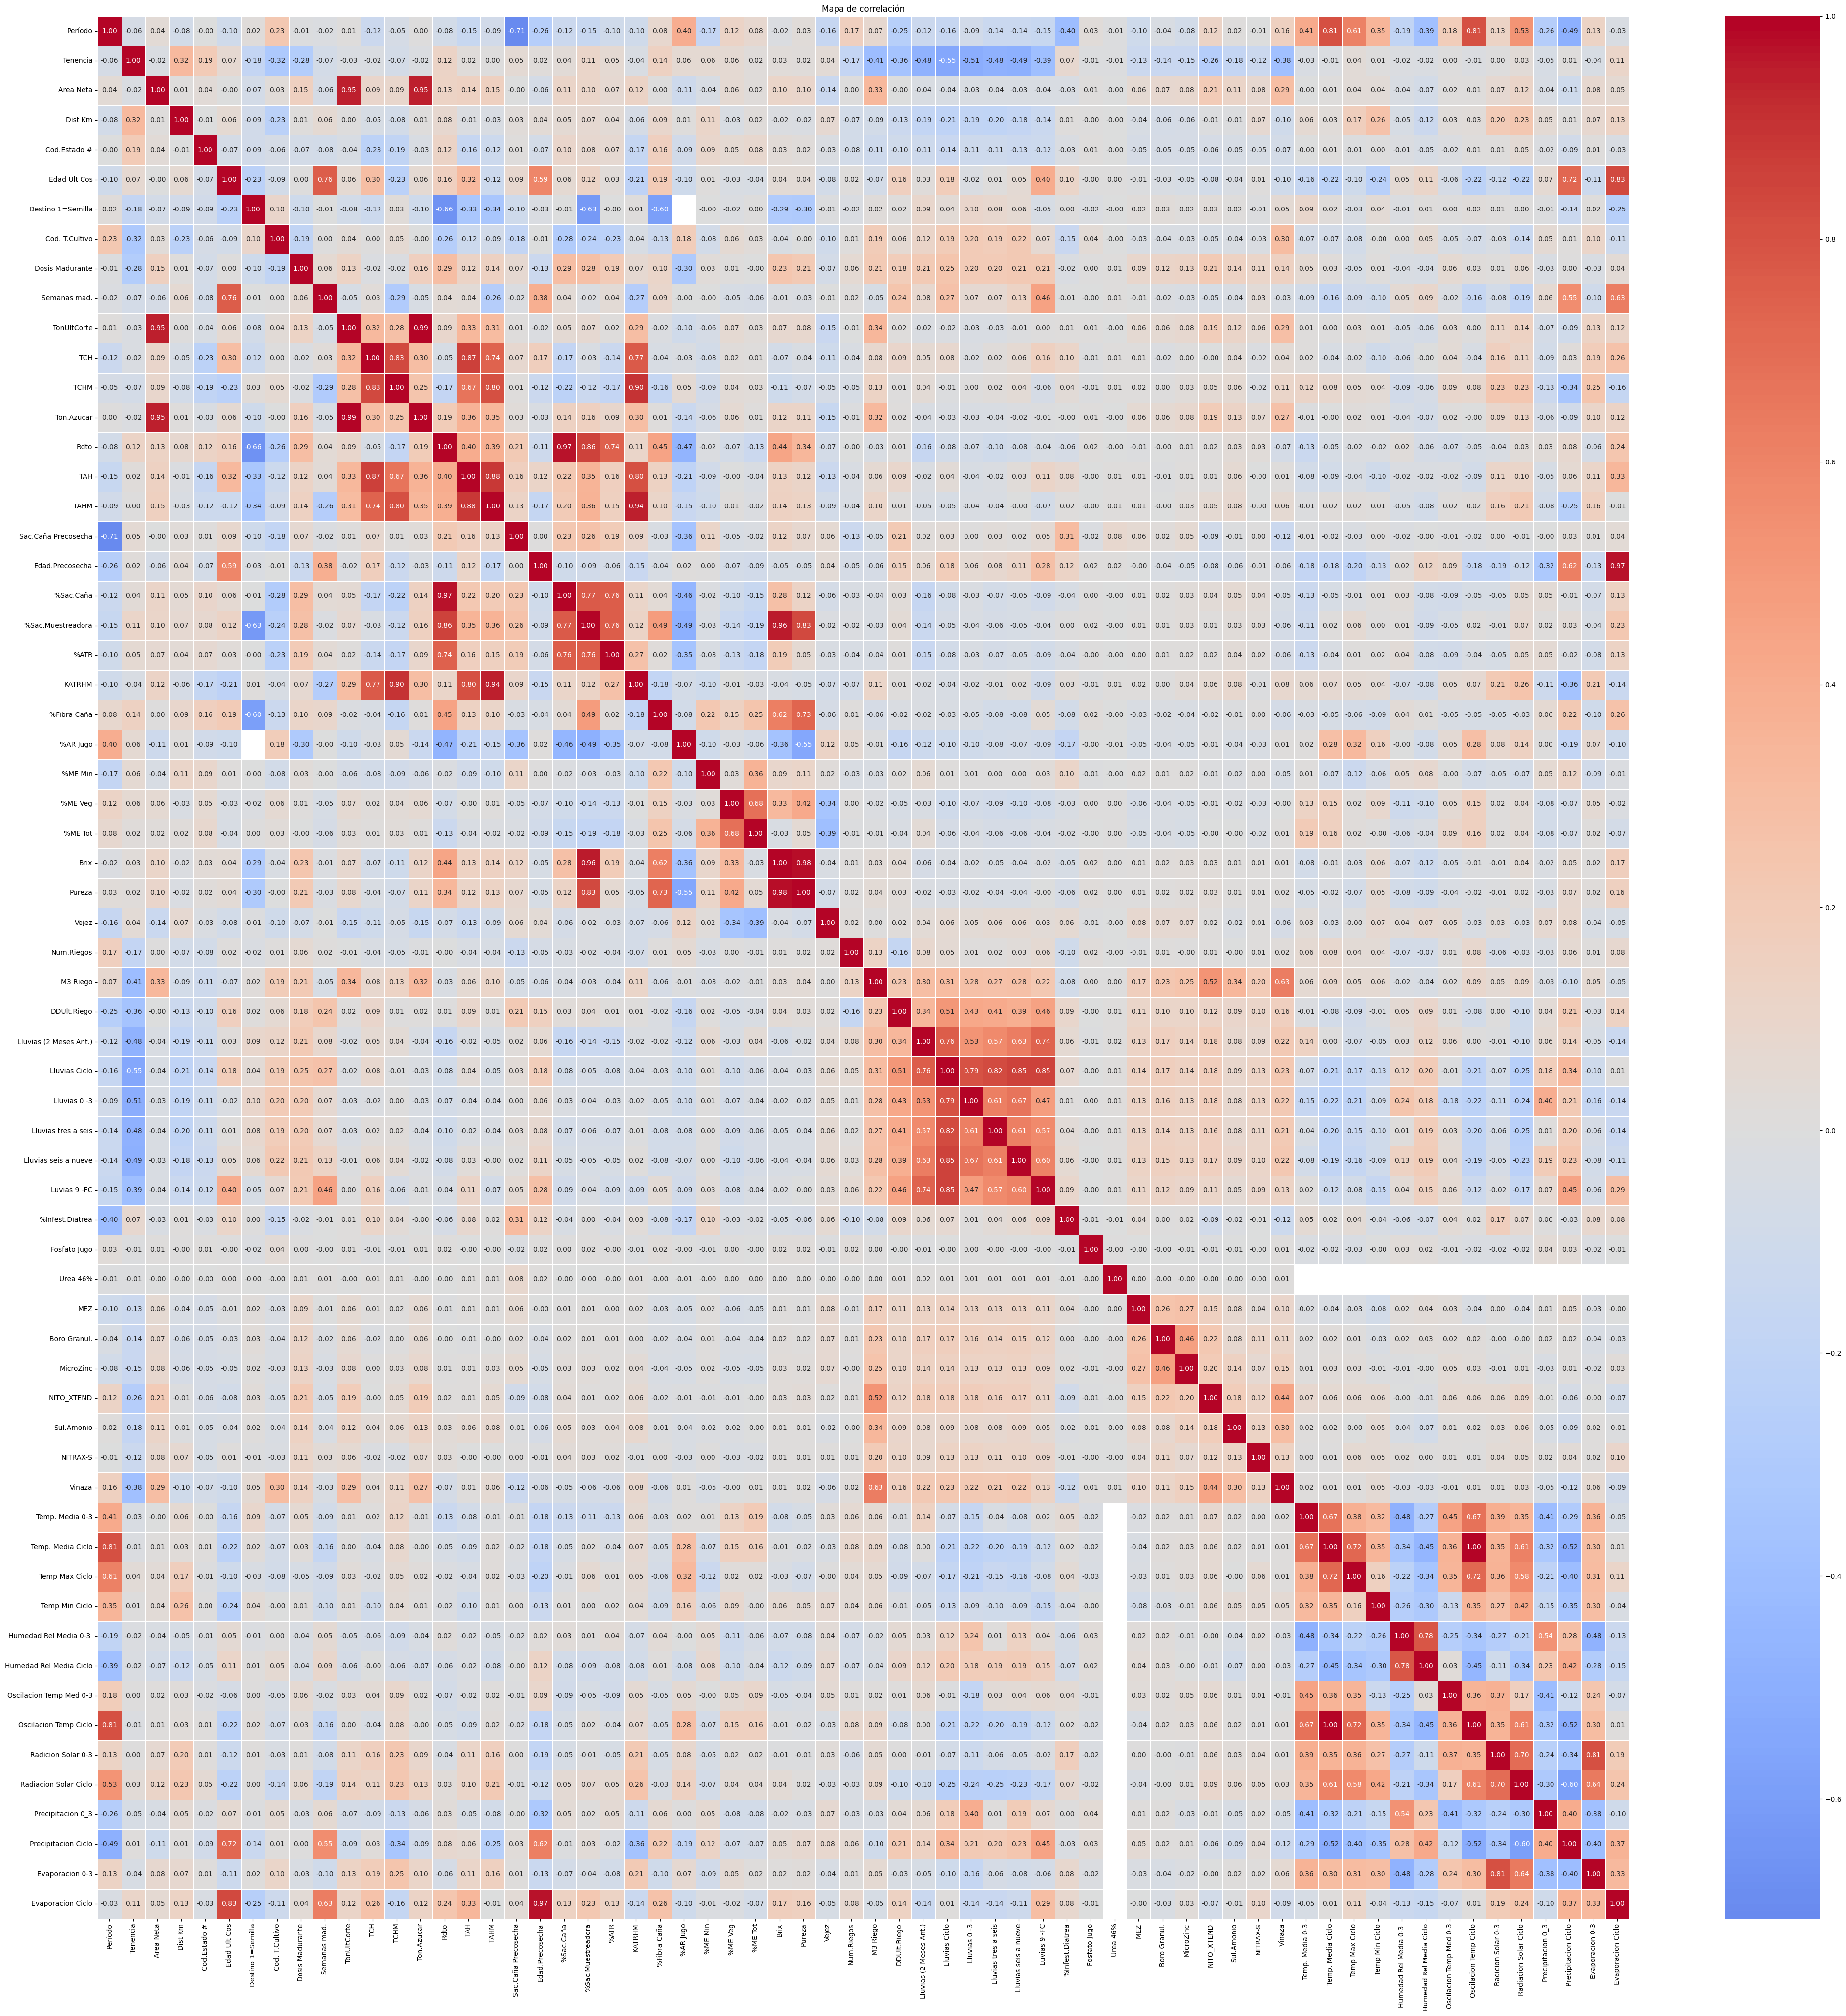

In [123]:
## Dataset original 
numeric_df_gen = df.select_dtypes(include=['float64', 'int64'])
numeric_df_gen_corr = numeric_df_gen.corr()

plt.figure(figsize=(50,50))
sns.heatmap(numeric_df_gen_corr, 
            annot=True,      
            cmap="coolwarm", 
            center=0,        
            fmt=".2f",       
            linewidths=0.5)  

plt.title("Mapa de correlación")
plt.show()


Se observa que no existe una correlación significativa con las variables del clima respecto a otras variables exceptuando a precipitación ciclo y a evaporación ciclo, se opta por eliminar a las demás y continuar con el análisis. 